![](http://thecads.org/wp-content/uploads/2017/02/adax_logo.jpg)
# Module 4: Data Manipulation and Analysis with Pandas

![](http://pandas.pydata.org/_static/pandas_logo.png)
[Pandas](http://pandas.pydata.org/) is a software library written for the Python programming language for data manipulation and analysis. In particular, it offers data structures and operations for manipulating numerical tables and time series. Pandas is free software released under the three-clause BSD license. The name is derived from the term _panel data_, an econometrics term for multidimensional structured data sets.

#### Contents
*[Continued from part 4a]*

* [Analyzing Data](#Analyzing-Data)
    * [Groupby](#Groupby) 
    * [MultiIndices](#MultiIndex)
    * [Pivot Tables](#Pivot-Tables) like Excel!
* [Example Analysis](#Example-Analysis)
* [Presenting Data](#Presenting-Data)
* [Summary](#Summary)

* [Other Topics](#Other-Topics)
    * [Merging DataFrames](#Merging-DataFrames)
    * [Apply Method](#Apply-method)
    * [Scales](#Scales)
    * [Dates Functionality](#Date-Functionality-in-Pandas)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Analyzing Data

The rest of this worksheet will use a single example, which contains data for customer counts per date at different store locations each week.  

In [33]:
# Function to generate test data
def CreateDataSet(Number=1):
    Output = []
    for i in range(Number):
        # Create a weekly (mondays) date range
        rng = pd.date_range(start='1/1/2013', end='12/31/2016', freq='W-MON')
        
        # Create random data
        data = np.random.randint(low=25,high=1000,size=len(rng))
        
        # Status pool
        status = [1,2,3]
        
        # Make a random list of statuses
        random_status = [status[np.random.randint(low=0,high=len(status))] for i in range(len(rng))]
        
        # State pool
        location = ['Bangsar','Ampang','Petaling Jaya','Cheras']
        
        # Make a random list of states 
        random_location = [location[np.random.randint(low=0,high=len(location))] for i in range(len(rng))]

        Output.extend(list(zip(random_location, random_status, data, rng)))
        
    return Output

In [ ]:
dataset = CreateDataSet(4)
df = pd.DataFrame(data=dataset, columns=['location','Status','CustomerCount','StatusDate'])
df.info()

In [ ]:
df.head()

We are now going to save this dataframe into an Excel file, to then bring it back to a dataframe. We simply do this to practice reading and writing to Excel files.  

We do not write the index values of the dataframe to the Excel file, since they are not meant to be part of our initial test data set.

In [ ]:
# Save results to Excel
df.to_excel('Customers.xlsx', index=False)
print('Done')

In [19]:
# Location of file
Location = r'Customers.xlsx'

# Parse a specific sheet - look what we did here!
df = pd.read_excel(Location, 0, index_col='StatusDate')
df.dtypes

location         object
Status            int64
CustomerCount     int64
dtype: object

In [20]:
# Return the index of df
df.index

DatetimeIndex(['2013-01-07', '2013-01-14', '2013-01-21', '2013-01-28',
               '2013-02-04', '2013-02-11', '2013-02-18', '2013-02-25',
               '2013-03-04', '2013-03-11',
               ...
               '2016-10-24', '2016-10-31', '2016-11-07', '2016-11-14',
               '2016-11-21', '2016-11-28', '2016-12-05', '2016-12-12',
               '2016-12-19', '2016-12-26'],
              dtype='datetime64[ns]', name='StatusDate', length=832, freq=None)

In [4]:
df.head()

,location,Status,CustomerCount
StatusDate,,,
2013-01-07,Cheras,3,450
2013-01-14,Ampang,1,602
2013-01-21,Petaling Jaya,1,860
2013-01-28,Ampang,2,852
2013-02-04,Petaling Jaya,1,893


In [5]:
# Let's pretend that status == only includes the people who 
# bought something. 
mask = df['Status'] == 1
df = df[mask]
df.shape

(241, 3)

At this point we may want to graph the data to check for any outliers or inconsistencies in the data. We will be using the ***plot()*** attribute of the dataframe.  

As you can see from the graph below it is not very conclusive and is probably a sign that we need to perform some more data preparation.

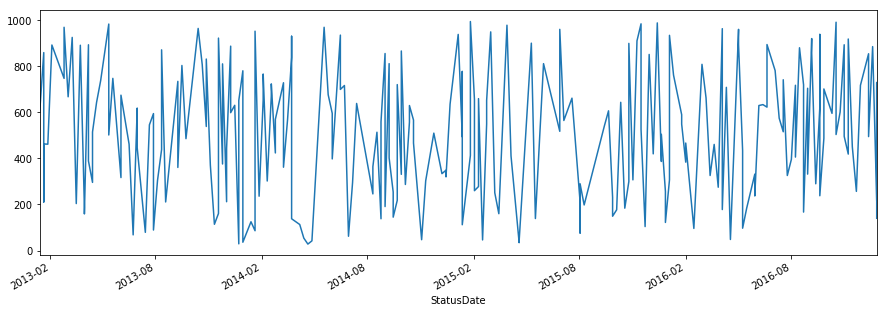

In [9]:
df['CustomerCount'].plot(figsize=(15,5))
plt.show()

If we take a look at the data, we begin to realize that there are multiple values for the same location, StatusDate, and Status combination. It is possible that this means the data you are working with is dirty/bad/inaccurate, but we will assume otherwise. We can assume this data set is a subset of a bigger data set and if we simply add the values in the ***CustomerCount*** column per location, StatusDate, and Status we will get the ***Total Customer Count*** per day.  

In [ ]:
sortdf = df[df['location']=='Bangsar'].sort_index(axis=0)
sortdf.head(10)

### Groupby
Our task is now to create a new dataframe that compresses the data so we have daily customer counts per location and StatusDate. We can ignore the Status column since the values in this column are of value *1*. To accomplish this we will use the dataframe's functions ***groupby*** and ***sum()***.  

Note that we are using **reset_index** . If we did not, we would not have been able to group by both the location and the StatusDate since the groupby function expects only columns as inputs. The **reset_index** function will bring the index ***StatusDate*** back to a column in the dataframe. 

In [25]:
# Group by State and StatusDate
Daily = df.reset_index().groupby(['location','StatusDate']).sum()
Daily.head(20)

Status  CustomerCount
location StatusDate                       
Ampang   2013-01-07       5           1722
         2013-01-14       3            909
         2013-01-28       6           1946
         2013-02-04       3            612
         2013-02-11       4           1416
         2013-02-18       2            420
         2013-02-25       5           2595
         2013-03-04       4           1309
         2013-03-11       3            682
         2013-03-18       3            466
         2013-03-25       3            363
         2013-04-08       4           1609
         2013-04-22       3            718
         2013-04-29       7           1555
         2013-05-06       2            661
         2013-05-13       1            984
         2013-05-20       2            307
         2013-05-27       4            341
         2013-06-03       1            675
         2013-06-10       3            403

The ***location*** and ***StatusDate*** columns are automatically placed in the index of the ***Daily*** dataframe. You can think of the ***index*** as the primary key of a database table but without the constraint of having unique values. Columns in the index as you will see allow us to easily select, plot, and perform calculations on the data.  

Below is how we can delete the ***Status*** column.

In [26]:
del Daily['Status']
Daily.head()

CustomerCount
location StatusDate               
Ampang   2013-01-07           1722
         2013-01-14            909
         2013-01-28           1946
         2013-02-04            612
         2013-02-11           1416

In [ ]:
# Try another groupby!

### MultiIndex

In [27]:
# What is the index of the Daily dataframe
Daily.index

MultiIndex(levels=[['Ampang', 'Bangsar', 'Cheras', 'Petaling Jaya'], [2013-01-07 00:00:00, 2013-01-14 00:00:00, 2013-01-21 00:00:00, 2013-01-28 00:00:00, 2013-02-04 00:00:00, 2013-02-11 00:00:00, 2013-02-18 00:00:00, 2013-02-25 00:00:00, 2013-03-04 00:00:00, 2013-03-11 00:00:00, 2013-03-18 00:00:00, 2013-03-25 00:00:00, 2013-04-01 00:00:00, 2013-04-08 00:00:00, 2013-04-15 00:00:00, 2013-04-22 00:00:00, 2013-04-29 00:00:00, 2013-05-06 00:00:00, 2013-05-13 00:00:00, 2013-05-20 00:00:00, 2013-05-27 00:00:00, 2013-06-03 00:00:00, 2013-06-10 00:00:00, 2013-06-17 00:00:00, 2013-06-24 00:00:00, 2013-07-01 00:00:00, 2013-07-08 00:00:00, 2013-07-15 00:00:00, 2013-07-22 00:00:00, 2013-07-29 00:00:00, 2013-08-05 00:00:00, 2013-08-12 00:00:00, 2013-08-19 00:00:00, 2013-08-26 00:00:00, 2013-09-02 00:00:00, 2013-09-09 00:00:00, 2013-09-16 00:00:00, 2013-09-23 00:00:00, 2013-09-30 00:00:00, 2013-10-07 00:00:00, 2013-10-14 00:00:00, 2013-10-21 00:00:00, 2013-10-28 00:00:00, 2013-11-04 00:00:00, 2013-1

In [31]:
# Select the location index
Daily.index.levels[0]

Index(['Ampang', 'Bangsar', 'Cheras', 'Petaling Jaya'], dtype='object', name='location')

### Pivot Tables

Are easy! and are akin to Excel.

In [34]:
# Let's Create the data set again.
dataset = CreateDataSet(4)
df = pd.DataFrame(data=dataset, columns=['location','Status','CustomerCount','StatusDate'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 832 entries, 0 to 831
Data columns (total 4 columns):
location         832 non-null object
Status           832 non-null int64
CustomerCount    832 non-null int64
StatusDate       832 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 26.1+ KB


In [35]:
pd.pivot_table(df, values = 'CustomerCount', 
               index = ['StatusDate','Status'],
               columns = ['location']).head()

location           Ampang  Bangsar  Cheras  Petaling Jaya
StatusDate Status                                        
2013-01-07 1        201.0      NaN     NaN            NaN
           2          NaN      NaN    69.0          413.0
           3          NaN    143.0     NaN            NaN
2013-01-14 2          NaN    287.0     NaN          558.0
           3        871.0      NaN     NaN          961.0

In [36]:
pd.pivot_table(df, values = 'CustomerCount', 
               index = ['StatusDate','location'],
               columns = ['Status']).head()

Status                        1      2      3
StatusDate location                          
2013-01-07 Ampang         201.0    NaN    NaN
           Bangsar          NaN    NaN  143.0
           Cheras           NaN   69.0    NaN
           Petaling Jaya    NaN  413.0    NaN
2013-01-14 Ampang           NaN    NaN  871.0

In [37]:
# aggfunc allows you to calculate some useful statistics aggregated over all entries in the dataframe
pd.pivot_table(df, values = 'CustomerCount', index = ['location'], aggfunc=('count','sum','mean','max','min'))

,count,sum,mean,max,min
location,,,,,
Ampang,209,105383,504.224880,995,33
Bangsar,199,100420,504.623116,998,29
Cheras,217,109702,505.539171,996,29
Petaling Jaya,207,104343,504.072464,997,27


In [41]:
# Design your own pivot tables to extract some meaningful information from the data!
pd.pivot_table(df, values = 'CustomerCount', index = ['Status'], aggfunc=('count','sum','mean','max','min'))

,count,sum,mean,max,min
Status,,,,,
1,287,148973,519.069686,997,30
2,276,136841,495.800725,995,29
3,269,134034,498.267658,998,27


## Example Analysis

Let's now plot the data per location.  

As you can see by breaking the graph up by the ***location*** column we have a much clearer picture on how the data looks like. **<font color="#ec1c24">Can you spot any outliers?</font>**

Ampang


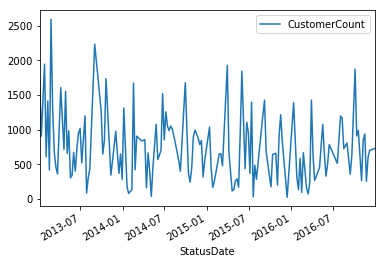

Bangsar


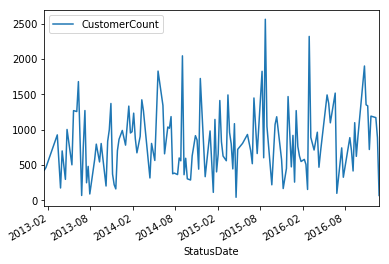

Cheras


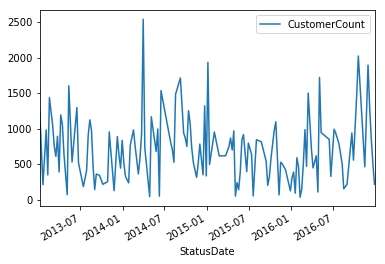

Petaling Jaya


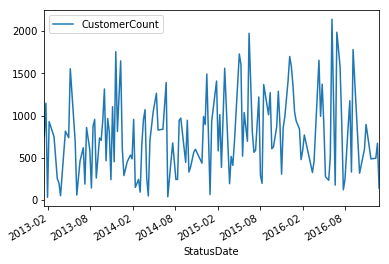

In [39]:
for place in Daily.index.levels[0]:
    print(place)
    Daily.loc[place].plot()
    plt.show();

We will assume that per month the customer count should remain relatively steady. Any data outside a specific range in that month will be removed from the data set. The final result should have smooth graphs with no spikes.  

***LocationYearMonth*** - Here we group by location, Year of StatusDate, and Month of StatusDate.  
***Daily['Outlier']*** - A boolean (True or False) value letting us know if the value in the CustomerCount column is ouside the acceptable range.  

We will be using the attribute ***transform*** instead of ***apply***. The reason is that transform will keep the shape(# of rows and columns) of the dataframe the same and apply will not. By looking at the previous graphs, we can realize they are not resembling a gaussian distribution, this means we cannot use summary statistics like the mean and stDev. We use percentiles instead. Note that we run the risk of eliminating good data.

In [42]:
# Calculate Outliers
LocationYearMonth = Daily.groupby([Daily.index.get_level_values(0), Daily.index.get_level_values(1).year, Daily.index.get_level_values(1).month])
Daily['Lower'] = LocationYearMonth['CustomerCount'].transform( lambda x: x.quantile(q=.25) - (1.5*x.quantile(q=.75)-x.quantile(q=.25)) )
Daily['Upper'] = LocationYearMonth['CustomerCount'].transform( lambda x: x.quantile(q=.75) + (1.5*x.quantile(q=.75)-x.quantile(q=.25)) )
Daily['Outlier'] = (Daily['CustomerCount'] < Daily['Lower']) | (Daily['CustomerCount'] > Daily['Upper']) 

# Remove Outliers
Daily = Daily[Daily['Outlier'] == False]

The dataframe named ***Daily*** will hold customer counts that have been aggregated per day. The original data (df) has multiple records per day.  We are left with a data set that is indexed by both the state and the StatusDate. The Outlier column should be equal to ***False*** signifying that the record is not an outlier.

In [43]:
Daily.head()

CustomerCount     Lower     Upper Outlier
location StatusDate                                           
Ampang   2013-01-07           1722  -120.000  3269.500   False
         2013-01-14            909  -120.000  3269.500   False
         2013-01-28           1946  -120.000  3269.500   False
         2013-02-04            612 -1438.125  3712.875   False
         2013-02-11           1416 -1438.125  3712.875   False

We create a separate dataframe named ***ALL*** which groups the Daily dataframe by StatusDate. We are essentially getting rid of the ***Location*** column. The ***Max*** column represents the maximum customer count per month. The ***Max*** column is used to smooth out the graph.

In [44]:
# Combine all markets

# Get the max customer count by Date
ALL = pd.DataFrame(Daily['CustomerCount'].groupby(Daily.index.get_level_values(1)).sum())
ALL.columns = ['CustomerCount'] # rename column

# Group by Year and Month
YearMonth = ALL.groupby([lambda x: x.year, lambda x: x.month])

# What is the max customer count per Year and Month
ALL['Max'] = YearMonth['CustomerCount'].transform(lambda x: x.max())
ALL.head()

,CustomerCount,Max
StatusDate,,
2013-01-07,2971,2971
2013-01-14,2093,2971
2013-01-21,1819,2971
2013-01-28,1979,2971
2013-02-04,2521,3343


As you can see from the ***ALL*** dataframe above, in the month of Jan 2013, the maximum customer count was 1702. If we had used ***apply***, we would have got a dataframe with (Year and Month) as the index and just the *Max* column with the value of 1702. 


----------------------------------  
There is also an interest to gauge if the current customer counts were reaching certain goals the company had established. The task here is to visually show if the current customer counts are meeting the goals listed below. We will call the goals ***BHAG*** (Big Hairy Annual Goal).  

* 12/31/2015 - 1,000 customers  
* 12/31/2016 - 2,000 customers  
* 12/31/2017 - 3,000 customers  

We will be using the **date_range** function to create our dates.  

***Definition:*** date_range(start=None, end=None, periods=None, freq='D', tz=None, normalize=False, name=None, closed=None)  
***Docstring:*** Return a fixed frequency datetime index, with day (calendar) as the default frequency  

By choosing the frequency to be ***A*** or annual we will be able to get the three target dates from above.

In [ ]:
pd.date_range?

# try it


# Presenting Data  

Create individual Graphs for each location

In [45]:
df['location'].unique()

array(['Ampang', 'Bangsar', 'Cheras', 'Petaling Jaya'], dtype=object)

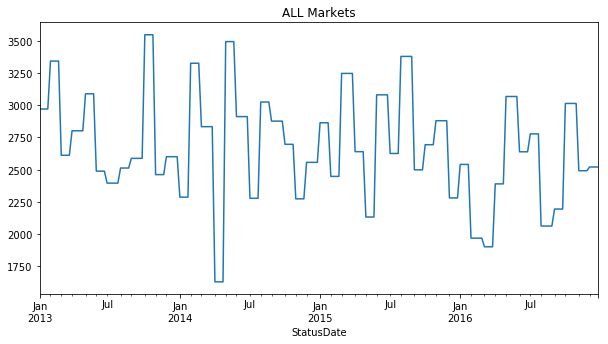

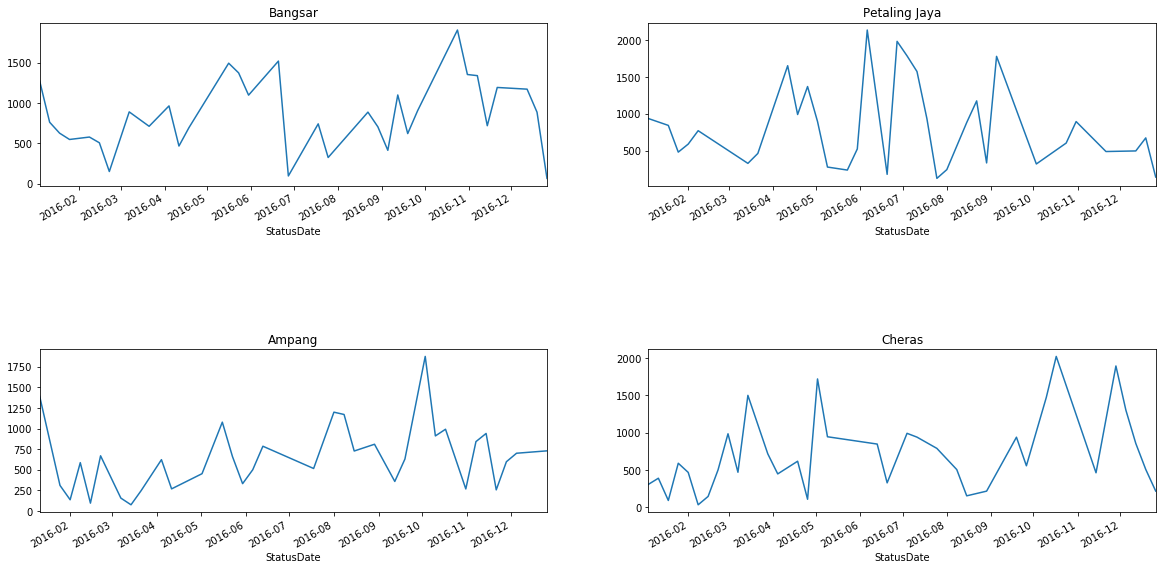

In [46]:
# First Graph
ALL['Max'].plot(figsize=(10, 5));plt.title('ALL Markets')

# Last four Graphs
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
fig.subplots_adjust(hspace=1.0) ## Create space between plots

Daily.loc['Bangsar']['CustomerCount']['2016':].fillna(method='pad').plot(ax=axes[0,0])
Daily.loc['Petaling Jaya']['CustomerCount']['2016':].fillna(method='pad').plot(ax=axes[0,1]) 
Daily.loc['Ampang']['CustomerCount']['2016':].fillna(method='pad').plot(ax=axes[1,0]) 
Daily.loc['Cheras']['CustomerCount']['2016':].fillna(method='pad').plot(ax=axes[1,1]) 

# Add titles
axes[0,0].set_title('Bangsar')
axes[0,1].set_title('Petaling Jaya')
axes[1,0].set_title('Ampang')
axes[1,1].set_title('Cheras')
plt.show();

## Summary

Pandas provides a "batteries-included" basic data analysis:
  - **Loading data:** `read_csv`, `read_table`, `read_sql`, and `read_html`
  - **Selection, filtering, and aggregation** (i.e., SQL-type operations): There's a special syntax for `SELECT`ing.  There's the `merge` method for `JOIN`ing.  There's also an easy syntax for what in SQL is a mouthful: Creating a new column whose value is computed from other column -- with the bonus that now the computations can use the full power of Python (though it might be faster if it didn't).
  - **"Pivot table" style aggregation**: If you're an Excel cognosceti, you may appreciate this.
  - **NA handling**: Like R's data frames, there is good support for transforming NA values with default values / averaging tricks / etc.
  - **Basic statistics:** e.g. `mean`, `median`, `max`, `min`, and the convenient `describe`.
  - **Plugging into more advanced analytics:** Okay, this isn't batteries included.  But still, it plays reasonably with `sklearn`.
  - **Visualization:** For instance `plot` and `hist`.
  
Plugging into more advanced analytics
-------
Almost any "advanced analytics" tool in the Python ecosystem is going to take as input `np.array` type arrays.  You can access the underlying array of a data frame column as

        df['column'].values
        
Many of them take `nd.array` whose underlying data can be accessed by 

        df.values
        
directly.  *Most* of the time, they will take `df['column']` and `df` without needing to look at values.

This is particularly important if you want to use Pandas with the sklearn library. See this [blog post](http://www.markhneedham.com/blog/2013/11/09/python-making-scikit-learn-and-pandas-play-nice/) for an example.

## Other Topics

### Merging Dataframes

In [ ]:
df = pd.DataFrame([{'Name': 'Chris', 'Item Purchased': 'Sponge', 'Cost': 22.50},
                   {'Name': 'Kevyn', 'Item Purchased': 'Kitty Litter', 'Cost': 2.50},
                   {'Name': 'Filip', 'Item Purchased': 'Spoon', 'Cost': 5.00}],
                  index=['Store 1', 'Store 1', 'Store 2'])
df

In [ ]:
df['Date'] = ['December 1', 'January 1', 'mid-May']
df

In [ ]:
df['Delivered'] = True
df

In [ ]:
df['Feedback'] = ['Positive', None, 'Negative']
df

In [ ]:
adf = df.reset_index()
adf['Date'] = pd.Series({0: 'December 1', 2: 'mid-May'})
adf.info()

In [ ]:
staff_df = pd.DataFrame([{'Name': 'Kelly', 'Role': 'Director of HR'},
                         {'Name': 'Sally', 'Role': 'Course liasion'},
                         {'Name': 'James', 'Role': 'Grader'}])
staff_df = staff_df.set_index('Name')

student_df = pd.DataFrame([{'Name': 'James', 'School': 'Business'},
                           {'Name': 'Mike', 'School': 'Law'},
                           {'Name': 'Sally', 'School': 'Engineering'}])
student_df = student_df.set_index('Name')
staff_df.head()
#student_df.head()


In [ ]:
pd.merge?

![](http://www.dofactory.com/Images/sql-joins.png)

In [ ]:
pd.merge(staff_df, student_df, how='outer', left_index=True, right_index=True)

In [ ]:
pd.merge(staff_df, student_df, how='inner', left_index=True, right_index=True)

In [ ]:
pd.merge(staff_df, student_df, how='left', left_index=True, right_index=True)

In [ ]:
pd.merge(staff_df, student_df, how='right', left_index=True, right_index=True)

In [ ]:
staff_df = staff_df.reset_index()
student_df = student_df.reset_index()
staff_df
student_df
pd.merge(staff_df, student_df, how='left', left_on='Name', right_on='Name')

In [ ]:
staff_df = pd.DataFrame([{'Name': 'Kelly', 'Role': 'Director of HR', 'Location': 'State Street'},
                         {'Name': 'Sally', 'Role': 'Course liasion', 'Location': 'Washington Avenue'},
                         {'Name': 'James', 'Role': 'Grader', 'Location': 'Washington Avenue'}])
student_df = pd.DataFrame([{'Name': 'James', 'School': 'Business', 'Location': '1024 Billiard Avenue'},
                           {'Name': 'Mike', 'School': 'Law', 'Location': 'Fraternity House #22'},
                           {'Name': 'Sally', 'School': 'Engineering', 'Location': '512 Wilson Crescent'}])
staff_df
student_df
pd.merge(staff_df, student_df, how='left', left_on='Name', right_on='Name')

In [ ]:
staff_df = pd.DataFrame([{'First Name': 'Kelly', 'Last Name': 'Desjardins', 'Role': 'Director of HR'},
                         {'First Name': 'Sally', 'Last Name': 'Brooks', 'Role': 'Course liasion'},
                         {'First Name': 'James', 'Last Name': 'Wilde', 'Role': 'Grader'}])
student_df = pd.DataFrame([{'First Name': 'James', 'Last Name': 'Hammond', 'School': 'Business'},
                           {'First Name': 'Mike', 'Last Name': 'Smith', 'School': 'Law'},
                           {'First Name': 'Sally', 'Last Name': 'Brooks', 'School': 'Engineering'}])
staff_df
student_df
pd.merge(staff_df, student_df, how='inner', left_on=['First Name','Last Name'], right_on=['First Name','Last Name'])

### Concatenate Dataframes

In [ ]:
pd.concat?

In [ ]:
df1 = pd.DataFrame({'A': ['A0', 'A1', 'A2', 'A3'],
                    'B': ['B0', 'B1', 'B2', 'B3'],
                    'C': ['C0', 'C1', 'C2', 'C3'],
                    'D': ['D0', 'D1', 'D2', 'D3']},
                    index=[0, 1, 2, 3])

df2 = pd.DataFrame({'A': ['A4', 'A5', 'A6', 'A7'],
                    'B': ['B4', 'B5', 'B6', 'B7'],
                    'C': ['C4', 'C5', 'C6', 'C7'],
                    'D': ['D4', 'D5', 'D6', 'D7']},
                    index=[4, 5, 6, 7])


df3 = pd.DataFrame({'A': ['A8', 'A9', 'A10', 'A11'],
                    'B': ['B8', 'B9', 'B10', 'B11'],
                    'C': ['C8', 'C9', 'C10', 'C11'],
                    'D': ['D8', 'D9', 'D10', 'D11']},
                     index=[8, 9, 10, 11])


df1
df2
df3
frames = [df1, df2, df3]

result = pd.concat([df2,df1,df3])

result

![](https://pandas.pydata.org/pandas-docs/stable/_images/merging_concat_basic.png)

In [ ]:
result = pd.concat(frames, keys=['Level1', 'Level2', 'Level3'])
result

What if the columns for both dataframes are not exactly the same (but with some overlaps) ?

In [ ]:
df4 = pd.DataFrame({'B': ['B2', 'B3', 'B6', 'B7'],
                    'D': ['D2', 'D3', 'D6', 'D7'],
                    'F': ['F2', 'F3', 'F6', 'F7']},
                    index=[2, 3, 6, 7])


result = pd.concat([df1, df4], axis=1)
result


![](https://pandas.pydata.org/pandas-docs/stable/_images/merging_concat_axis1.png)

### Apply functions over the columns

apply() can apply a function along any axis of the dataframe

In [ ]:
data = {'name': ['Jason', 'Molly', 'Tina', 'Jake', 'Amy'],
        'year': [2012, 2012, 2013, 2014, 2014],
        'reports': [4, 24, 31, 2, 3],
        'coverage': [25, 94, 57, 62, 70]}
df = pd.DataFrame(data, index = ['Cochice', 'Pima', 'Santa Cruz', 'Maricopa', 'Yuma'])
df

In [ ]:
df.apply?

In [ ]:
# Create a capitalization lambda function
capitalizer = lambda x: x.upper()

In [ ]:
df['name'].apply(capitalizer)
df['name'].apply(lambda x: x.upper())
df.name.apply(lambda x: x.upper())

Map the capitalizer lambda function over each element in the series 'name' using map()

In [ ]:
df['name'].map(capitalizer)

Apply a square function to every single cell in the whole data frame using applymap()

In [ ]:
# Drop the string variable so that applymap() can run
#df = df.drop('name', axis=1)

# Return the square of every cell in the dataframe
df.applymap(np.square)

### Apply functions over a Dataframe
Create a function that multiplies all non-strings by 100

In [ ]:
# create a function called times100
def times100(x):
    # that, if x is a string,
    if type(x) is str:
        # just returns it untouched
        return x
    # but, if not, return it multiplied by 100
    elif x:
        return 100 * x
    # and leave everything else
    else:
        return

df.applymap(times100)

## Scales

* **Ratio Scale:**
    * units are equally spaced
    * mathematical operations of +-*/ are all valid
    * e.g. height and weight
* **Interval scale:**
    * units are equally spaced but there are no true zero
    * e.g. Temperature in Celcius, where 0C means is not true zero
* **Ordinal scale:**
    * the order of the units is important, but not evenly spaced
    * Letter grades such as A+, A are a good example
* **Nominal scale:**
    * sometimes called categorical data
    * categories of data but the categories have no order with respect to one another
    * Teams of a sport

In [ ]:
df = pd.DataFrame(['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D'],
                  index=['excellent', 'excellent', 'excellent', 'good', 'good', 'good', 'ok', 'ok', 'ok', 'poor', 'poor'])
df.rename(columns={0: 'Grades'}, inplace=True)
df

In [ ]:
df['Grades'].astype('category')

In [ ]:
grades = df['Grades'].astype('category',
                             categories=['D', 'D+', 'C-', 'C', 'C+', 'B-', 'B', 'B+', 'A-', 'A', 'A+'],
                             ordered=True)
grades

In [ ]:
grades > 'C'
grades[grades>'C']

# Date Functionality in Pandas

Following table shows the type of time-related classes pandas can handle and how to create them.

| Class         |      Remarks                    |  How to create |
|---------------|:-------------------------------:|---------------:|
| `Timestamp`	    |  Represents a single time stamp | `to_datetime`, `Timestamp` |
| `DatetimeIndex` |    Index of Timestamp           | `to_datetime`, `date_range`, `DatetimeIndex`|
| `Period`        | Represents a single time span   |    `Period`          |
| `PeriodIndex`   | Index of a Period               |`period_range`,`PeriodIndex` |



### Timestamp

In [ ]:
pd.Timestamp?

In [ ]:
pd.Timestamp('9/1/2016 10:05AM')

### Period

In [ ]:
pd.Period?

In [ ]:
pd.Period('1/2016')

In [ ]:
pd.Period('2016')

### DatetimeIndex

In [ ]:
t1 = pd.Series(list('abc'), [pd.Timestamp('2016-09-01'), pd.Timestamp('2016-09-02'), pd.Timestamp('2016-09-03')])
t1

In [ ]:
type(t1.index)

### PeriodIndex

In [ ]:
t2 = pd.Series(list('def'), [pd.Period('2016-09'), pd.Period('2016-10'), pd.Period('2016-11')])
t2

In [ ]:
type(t2.index)

### Converting to Datetime

In [ ]:
d1 = ['2 June 2013', 'Aug 29, 2014', '2015-06-26', '7/12/16']
ts3 = pd.DataFrame(np.random.randint(10, 100, (4,2)), index=d1, columns=list('ab'))
ts3

In [ ]:
pd.to_datetime?

In [ ]:
ts3.index = pd.to_datetime(ts3.index)
ts3

In [ ]:
date1 = pd.to_datetime('7/12/2016 13:00:00', format ='%d/%m/%Y %H:%M:%S')

date2 = pd.to_datetime('9/12/2016 14:00:00', format ='%d/%m/%Y %H:%M:%S')

date2 - date1

In [ ]:
pd.to_datetime('4.7.12', dayfirst=True)

### Timedeltas

In [ ]:
pd.Timestamp('9/3/2016')-pd.Timestamp('9/1/2016')

In [ ]:
pd.Timestamp('9/2/2016 8:10AM') + pd.Timedelta('12D 3H')

### Working with Dates in a Dataframe

In [ ]:
dates = pd.date_range('10-01-2016', periods=9, freq='2W-SUN')
dates

In [ ]:
np.random.seed(100)
df = pd.DataFrame({'Count 1': 100 + np.random.randint(-5, 10, 9).cumsum(),
                  'Count 2': 120 + np.random.randint(-5, 10, 9)}, index=dates)
df

In [ ]:
df.index.weekday_name

In [ ]:
df.diff?

In [ ]:
df.diff()

In [ ]:
df.resample?

In [ ]:
df.resample('D').mean()

In [ ]:
df['2017']

In [ ]:
df['2016-12']

In [ ]:
df['2016-12':]

In [ ]:
df.asfreq('W', method='ffill')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

df.plot();